# LSTM basic

# Import libraries

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import scipy
import os
import string
import csv
import random as rn

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing
import spacy
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import re
from string import punctuation
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Dense, Dropout, LSTM

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
import shutil
from sklearn import metrics
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
from sklearn.utils import class_weight
from keras import backend as K

from attention import Attention

In [ ]:
pip install attention

# Load dataset

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cp --verbose -R "/content/drive/MyDrive/Quora/Dataset" "/content"

# Set Parameters

In [ ]:
DATASET_PATH = '/content/Dataset'

LOCAL_MODELS_FOLDER = "/content/Models"
if not os.path.exists(LOCAL_MODELS_FOLDER):
  os.makedirs(LOCAL_MODELS_FOLDER)
GLOBAL_MODELS_FOLDER = "/content/drive/My Drive/Quora/Models/LSTM"

HISTORIES_FOLDER = "/content/drive/My Drive/Quora/Histories/LSTM"

BATCH_SIZE = 64
SEED = 24

# Utility Functions

In [ ]:
def set_seed ():
  ''' 
  set_seed is used to obtain reproducible results using keras during the development phase
  '''
  # The below is necessary for reproducible results of certain Python hash-based operations.
  os.environ["PYTHONHASHSEED"]="0"
  # The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
  np.random.seed(SEED)
  # The below is necessary for starting core Python generated random numbers in a well-defined state.
  rn.seed(SEED)
  # The below tf.random.set_seed will make random number generation in TensorFlow have a well-defined initial state.
  tf.random.set_seed(SEED)

def show_training_and_validation_performance(history):
  '''
  show_training_and_validation_performance is used to plot the performances during the training phase
  :param history: object in which are recorded all the events
  '''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

def compile_model (model, optimizer='adam', learning_rate = 0.001):
  '''
  compile_model is used to compile the current model
  :param model: model to compile
  :param optimizer: optimizer to be used
  :param learning_rate: learning rate parameter for the optimizer
  '''
  if optimizer == 'adam':
    model.compile(loss="binary_crossentropy",
      optimizer=optimizers.Adam(learning_rate=learning_rate),
      metrics=["accuracy"])
  elif optimizer == 'rmsprop':
    model.compile(loss="binary_crossentropy",
                  optimizer = optimizers.RMSprop(learning_rate=learning_rate),
                  metrics=['accuracy'])
  model.summary()

def run_model (model, model_name, X_train, y_train, X_validation, y_validation, epochs = 50, patience = 5, monitor='val_loss', class_weight=None):
  '''
  run_model is used to run the current mode
  :param model: model to run
  :param model_name: name given to save the model
  :param epochs: how many epochs to do
  :param patience: patience value for Early Stopping
  :param monitor: what to monitor for Early Stopping and Model Checkpoint
  '''
  # local save path for the models
  save_path = LOCAL_MODELS_FOLDER + '/' + model_name + '.h5'
  callbacks_list = [
                  keras.callbacks.EarlyStopping(monitor=monitor, patience=patience),
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor=monitor,
                      verbose=1,
                      save_best_only=True)
                  ]
  history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_validation, y_validation),
                    callbacks=callbacks_list,
                    class_weight=class_weight)
  # save on Drive only the best model
  shutil.copy(save_path, GLOBAL_MODELS_FOLDER + '/' + model_name + '.h5')

  # save on Drive also the history object
  history_df = pd.DataFrame(history.history)
  with open(HISTORIES_FOLDER + '/' + model_name + '.csv', mode='w+') as f:
    history_df.to_csv(f)

  show_training_and_validation_performance(history)

def evaluate_model (model, X_test, y_test):
  '''
  evaluate_model is used to plot some statistics about the performance on the test set
  :param model: model to consider
  '''
  y_score = model.predict(X_test)
  y_pred = np.rint(y_score) # to have 0 or 1
  y_true = y_test
  print("Classification report: ")
  print(metrics.classification_report(y_true,y_pred,digits = 4))
  metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

  # ROC curve
  fpr,tpr,th = metrics.roc_curve(y_true,y_score)
  roc_auc = metrics.roc_auc_score(y_true,y_score)

  plt.figure()
  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  plt.legend(loc="lower right")
  plt.show()

def txt_process(input_text):
  '''
  txt_process is used to preprocess a question
  :param input_text: input string
  :return: the cleaned version of the input string
  '''
  # Removing punctuation from input text
  input_text = ''.join([x for x in input_text if x not in punctuation])
  # Cleaning the text
  input_text = re.sub(r"[^A-Za-z0-9]", " ", input_text)
  input_text = re.sub(r"\'s", " ", input_text)
  # remove stop words
  input_text = input_text.split()
  input_text = [x for x in input_text if not x in stop_words]
  input_text = " ".join(input_text)
  # return a list of words
  return(input_text)

# Preprocessing data

In [ ]:
train_questions = pd.read_csv(DATASET_PATH + '/training.csv')
validation_questions = pd.read_csv(DATASET_PATH + '/validation.csv')
test_questions = pd.read_csv(DATASET_PATH + '/test.csv')

In [ ]:
train_questions

,id,qid1,qid2,question1,question2,is_duplicate
0,216036,322068,322069,How can I sell at Snapdeal? What are the terms...,What are the payment terms for online marketpl...,0
1,241554,353581,353582,Why are most prosecutors in American courts no...,Why does a country like USA where law enforcem...,0
2,208738,312815,312816,What are some good government jobs without a c...,Are there any good companies that hire smart p...,0
3,102714,104282,77231,What would happen if humans no longer needed t...,What would the world be like if humans didn't ...,1
4,397304,178955,34172,How do I shave my bikini line?,What is the best way to shave the bikini area?,1
...,...,...,...,...,...,...
323426,189944,8395,34814,Is it true that the US is funding ISIS?,Is it really true that US is backing ISIS?,1
323427,330730,110579,457526,How do I play in share market in India?,How can I study and invest in the Indian share...,0
323428,143114,226824,175127,What is the difference between laundry deterge...,How safe is it to use non-HE detergent in a HE...,0
323429,10918,21121,21122,Would you consider teaching as a full time job...,Would you consider teaching as a full time job?,1


In [ ]:
train_questions['question1_cleaned'] = train_questions.apply(lambda x: txt_process(x['question1']), axis = 1)
train_questions['question2_cleaned'] = train_questions.apply(lambda x: txt_process(x['question2']), axis = 1)

validation_questions['question1_cleaned'] = validation_questions.apply(lambda x: txt_process(x['question1']), axis = 1)
validation_questions['question2_cleaned'] = validation_questions.apply(lambda x: txt_process(x['question2']), axis = 1)

test_questions['question1_cleaned'] = test_questions.apply(lambda x: txt_process(x['question1']), axis = 1)
test_questions['question2_cleaned'] = test_questions.apply(lambda x: txt_process(x['question2']), axis = 1)

In [ ]:
train_questions

,id,qid1,qid2,question1,question2,is_duplicate,question1_cleaned,question2_cleaned
0,216036,322068,322069,How can I sell at Snapdeal? What are the terms...,What are the payment terms for online marketpl...,0,How I sell Snapdeal What terms conditions,What payment terms online marketplaces like Fl...
1,241554,353581,353582,Why are most prosecutors in American courts no...,Why does a country like USA where law enforcem...,0,Why prosecutors American courts notoriously di...,Why country like USA law enforcements strict l...
2,208738,312815,312816,What are some good government jobs without a c...,Are there any good companies that hire smart p...,0,What good government jobs without college degree,Are good companies hire smart people without c...
3,102714,104282,77231,What would happen if humans no longer needed t...,What would the world be like if humans didn't ...,1,What would happen humans longer needed sleep,What would world like humans didnt need sleep
4,397304,178955,34172,How do I shave my bikini line?,What is the best way to shave the bikini area?,1,How I shave bikini line,What best way shave bikini area
...,...,...,...,...,...,...,...,...
323426,189944,8395,34814,Is it true that the US is funding ISIS?,Is it really true that US is backing ISIS?,1,Is true US funding ISIS,Is really true US backing ISIS
323427,330730,110579,457526,How do I play in share market in India?,How can I study and invest in the Indian share...,0,How I play share market India,How I study invest Indian share market
323428,143114,226824,175127,What is the difference between laundry deterge...,How safe is it to use non-HE detergent in a HE...,0,What difference laundry detergent bleach laund...,How safe use nonHE detergent HE laundry washer
323429,10918,21121,21122,Would you consider teaching as a full time job...,Would you consider teaching as a full time job?,1,Would consider teaching full time job Why,Would consider teaching full time job


# Use Tokenization

# Text to Feature
Let’s stack both question IDs together so we can cover all words from both columns. Then we can tokenize these words to convert them to numbers. Some questions are very long, we considered only the first 25 words for each question.

In [ ]:
#stacking
question_text = np.hstack([train_questions.question1_cleaned, train_questions.question2_cleaned])

#tokenizing
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(question_text)

# define the max length of the single tokenizer
max_len_tokenizers = 25

#creating new columns for both ids where tokenized form of sentence is created
train_questions['tokenizer_1'] = tokenizer.texts_to_sequences(train_questions.question1_cleaned)
train_questions['tokenizer_1'] = sequence.pad_sequences(train_questions.tokenizer_1, maxlen = max_len_tokenizers, padding='post', truncating='post').tolist()
train_questions['tokenizer_2'] = tokenizer.texts_to_sequences(train_questions.question2_cleaned)
train_questions['tokenizer_2'] = sequence.pad_sequences(train_questions.tokenizer_2, maxlen = max_len_tokenizers, padding='post', truncating='post').tolist()

validation_questions['tokenizer_1'] = tokenizer.texts_to_sequences(validation_questions.question1_cleaned)
validation_questions['tokenizer_1'] = sequence.pad_sequences(validation_questions.tokenizer_1, maxlen = max_len_tokenizers, padding='post', truncating='post').tolist()
validation_questions['tokenizer_2'] = tokenizer.texts_to_sequences(validation_questions.question2_cleaned)
validation_questions['tokenizer_2'] = sequence.pad_sequences(validation_questions.tokenizer_2, maxlen = max_len_tokenizers, padding='post', truncating='post').tolist()

test_questions['tokenizer_1'] = tokenizer.texts_to_sequences(test_questions.question1_cleaned)
test_questions['tokenizer_1'] = sequence.pad_sequences(test_questions.tokenizer_1, maxlen = max_len_tokenizers, padding='post', truncating='post').tolist()
test_questions['tokenizer_2'] = tokenizer.texts_to_sequences(test_questions.question2_cleaned)
test_questions['tokenizer_2'] = sequence.pad_sequences(test_questions.tokenizer_2, maxlen = max_len_tokenizers, padding='post', truncating='post').tolist()

train_questions.head(5)

,id,qid1,qid2,question1,question2,is_duplicate,question1_cleaned,question2_cleaned,tokenizer_1,tokenizer_2
0,216036,322068,322069,How can I sell at Snapdeal? What are the terms...,What are the payment terms for online marketpl...,0,How I sell Snapdeal What terms conditions,What payment terms online marketplaces like Fl...,"[4, 3, 522, 4905, 2, 466, 3146, 0, 0, 0, 0, 0,...","[2, 1603, 466, 47, 14382, 13, 2223, 7716, 4905..."
1,241554,353581,353582,Why are most prosecutors in American courts no...,Why does a country like USA where law enforcem...,0,Why prosecutors American courts notoriously di...,Why country like USA law enforcements strict l...,"[5, 28363, 292, 4730, 32476, 12231, 1100, 145,...","[5, 135, 13, 208, 404, 75956, 6164, 2008, 1221..."
2,208738,312815,312816,What are some good government jobs without a c...,Are there any good companies that hire smart p...,0,What good government jobs without college degree,Are good companies hire smart people without c...,"[2, 14, 164, 334, 44, 125, 418, 0, 0, 0, 0, 0,...","[42, 14, 181, 797, 770, 11, 44, 125, 418, 0, 0..."
3,102714,104282,77231,What would happen if humans no longer needed t...,What would the world be like if humans didn't ...,1,What would happen humans longer needed sleep,What would world like humans didnt need sleep,"[2, 15, 119, 475, 1192, 1143, 412, 0, 0, 0, 0,...","[2, 15, 50, 13, 475, 490, 92, 412, 0, 0, 0, 0,..."
4,397304,178955,34172,How do I shave my bikini line?,What is the best way to shave the bikini area?,1,How I shave bikini line,What best way shave bikini area,"[4, 3, 3379, 6390, 702, 0, 0, 0, 0, 0, 0, 0, 0...","[2, 6, 18, 3379, 6390, 619, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
num_distinct_words = len(tokenizer.word_index)
num_distinct_words

96689

Combining both tokens of question1 and question2

In [ ]:
train_questions['tokenizer'] = train_questions['tokenizer_1'] + train_questions['tokenizer_2']
validation_questions['tokenizer'] = validation_questions['tokenizer_1'] + validation_questions['tokenizer_2']
test_questions['tokenizer'] = test_questions['tokenizer_1'] + test_questions['tokenizer_2']

# defining total max length
m_len = max_len_tokenizers * 2

train_questions

,id,qid1,qid2,question1,question2,is_duplicate,question1_cleaned,question2_cleaned,tokenizer_1,tokenizer_2,tokenizer
0,216036,322068,322069,How can I sell at Snapdeal? What are the terms...,What are the payment terms for online marketpl...,0,How I sell Snapdeal What terms conditions,What payment terms online marketplaces like Fl...,"[4, 3, 522, 4905, 2, 466, 3146, 0, 0, 0, 0, 0,...","[2, 1603, 466, 47, 14382, 13, 2223, 7716, 4905...","[4, 3, 522, 4905, 2, 466, 3146, 0, 0, 0, 0, 0,..."
1,241554,353581,353582,Why are most prosecutors in American courts no...,Why does a country like USA where law enforcem...,0,Why prosecutors American courts notoriously di...,Why country like USA law enforcements strict l...,"[5, 28363, 292, 4730, 32476, 12231, 1100, 145,...","[5, 135, 13, 208, 404, 75956, 6164, 2008, 1221...","[5, 28363, 292, 4730, 32476, 12231, 1100, 145,..."
2,208738,312815,312816,What are some good government jobs without a c...,Are there any good companies that hire smart p...,0,What good government jobs without college degree,Are good companies hire smart people without c...,"[2, 14, 164, 334, 44, 125, 418, 0, 0, 0, 0, 0,...","[42, 14, 181, 797, 770, 11, 44, 125, 418, 0, 0...","[2, 14, 164, 334, 44, 125, 418, 0, 0, 0, 0, 0,..."
3,102714,104282,77231,What would happen if humans no longer needed t...,What would the world be like if humans didn't ...,1,What would happen humans longer needed sleep,What would world like humans didnt need sleep,"[2, 15, 119, 475, 1192, 1143, 412, 0, 0, 0, 0,...","[2, 15, 50, 13, 475, 490, 92, 412, 0, 0, 0, 0,...","[2, 15, 119, 475, 1192, 1143, 412, 0, 0, 0, 0,..."
4,397304,178955,34172,How do I shave my bikini line?,What is the best way to shave the bikini area?,1,How I shave bikini line,What best way shave bikini area,"[4, 3, 3379, 6390, 702, 0, 0, 0, 0, 0, 0, 0, 0...","[2, 6, 18, 3379, 6390, 619, 0, 0, 0, 0, 0, 0, ...","[4, 3, 3379, 6390, 702, 0, 0, 0, 0, 0, 0, 0, 0..."
...,...,...,...,...,...,...,...,...,...,...,...
323426,189944,8395,34814,Is it true that the US is funding ISIS?,Is it really true that US is backing ISIS?,1,Is true US funding ISIS,Is really true US backing ISIS,"[7, 180, 38, 1578, 1304, 0, 0, 0, 0, 0, 0, 0, ...","[7, 79, 180, 38, 10459, 1304, 0, 0, 0, 0, 0, 0...","[7, 180, 38, 1578, 1304, 0, 0, 0, 0, 0, 0, 0, ..."
323427,330730,110579,457526,How do I play in share market in India?,How can I study and invest in the Indian share...,0,How I play share market India,How I study invest Indian share market,"[4, 3, 231, 676, 293, 10, 0, 0, 0, 0, 0, 0, 0,...","[4, 3, 150, 491, 37, 676, 293, 0, 0, 0, 0, 0, ...","[4, 3, 231, 676, 293, 10, 0, 0, 0, 0, 0, 0, 0,..."
323428,143114,226824,175127,What is the difference between laundry deterge...,How safe is it to use non-HE detergent in a HE...,0,What difference laundry detergent bleach laund...,How safe use nonHE detergent HE laundry washer,"[2, 28, 7495, 6195, 3493, 7495, 6195, 44, 3493...","[4, 204, 32, 36566, 6195, 1289, 7495, 10332, 0...","[2, 28, 7495, 6195, 3493, 7495, 6195, 44, 3493..."
323429,10918,21121,21122,Would you consider teaching as a full time job...,Would you consider teaching as a full time job?,1,Would consider teaching full time job Why,Would consider teaching full time job,"[15, 995, 2742, 623, 25, 54, 5, 0, 0, 0, 0, 0,...","[15, 995, 2742, 623, 25, 54, 0, 0, 0, 0, 0, 0,...","[15, 995, 2742, 623, 25, 54, 5, 0, 0, 0, 0, 0,..."


In [ ]:
train_questions[train_questions.columns[[3,4, 6, 7]]]

,question1,question2,question1_cleaned,question2_cleaned
0,How can I sell at Snapdeal? What are the terms...,What are the payment terms for online marketpl...,How I sell Snapdeal What terms conditions,What payment terms online marketplaces like Fl...
1,Why are most prosecutors in American courts no...,Why does a country like USA where law enforcem...,Why prosecutors American courts notoriously di...,Why country like USA law enforcements strict l...
2,What are some good government jobs without a c...,Are there any good companies that hire smart p...,What good government jobs without college degree,Are good companies hire smart people without c...
3,What would happen if humans no longer needed t...,What would the world be like if humans didn't ...,What would happen humans longer needed sleep,What would world like humans didnt need sleep
4,How do I shave my bikini line?,What is the best way to shave the bikini area?,How I shave bikini line,What best way shave bikini area
...,...,...,...,...
323426,Is it true that the US is funding ISIS?,Is it really true that US is backing ISIS?,Is true US funding ISIS,Is really true US backing ISIS
323427,How do I play in share market in India?,How can I study and invest in the Indian share...,How I play share market India,How I study invest Indian share market
323428,What is the difference between laundry deterge...,How safe is it to use non-HE detergent in a HE...,What difference laundry detergent bleach laund...,How safe use nonHE detergent HE laundry washer
323429,Would you consider teaching as a full time job...,Would you consider teaching as a full time job?,Would consider teaching full time job Why,Would consider teaching full time job


# Model implementation
We don't need all the information of the DataFrame, we will focus now on the "tokenizer" and "is_duplicate" column

In [ ]:
y_train = train_questions[['is_duplicate']]
X_train = train_questions[['tokenizer']]
y_validation = validation_questions[['is_duplicate']]
X_validation = validation_questions[['tokenizer']]
y_test = test_questions[['is_duplicate']]
X_test = test_questions[['tokenizer']]

# padding X_train with a maximum length
X_train = sequence.pad_sequences(X_train.tokenizer, maxlen = m_len, padding='post', truncating='post')
X_validation = sequence.pad_sequences(X_validation.tokenizer, maxlen = m_len, padding='post', truncating='post')
X_test = sequence.pad_sequences(X_test.tokenizer, maxlen = m_len, padding='post', truncating='post')

In [ ]:
# class weight
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(y_train),
                                                 y=y_train['is_duplicate'].tolist())

class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{0: 0.7919194738672034, 1: 1.3564005569348454}

## Experiment 1

In [ ]:
#defining the model
model = Sequential()
#adding embeedding layer
model.add(Embedding(num_distinct_words, 64))
#adding drop out layer
model.add(Dropout(0.15))
#LSTM layer
model.add(LSTM(16))
#adding sigmoid layer
model.add(Dense(1, activation = 'sigmoid'))

compile_model(model)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 64)          6188096   
                                                                 
 dropout_3 (Dropout)         (None, None, 64)          0         
                                                                 
 lstm_3 (LSTM)               (None, 16)                5184      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 6,193,297
Trainable params: 6,193,297
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
5054/5054 [==============================] - ETA: 0s - loss: 0.4957 - accuracy: 0.7598
Epoch 1: val_loss improved from inf to 0.47950, saving model to /content/Models/LSTM16.h5
5054/5054 [==============================] - 416s 82ms/step - loss: 0.4957 - accuracy: 0.7598 - val_loss: 0.4795 - val_accuracy: 0.7697
Epoch 2/5
5054/5054 [==============================] - ETA: 0s - loss: 0.4258 - accuracy: 0.7991
Epoch 2: val_loss improved from 0.47950 to 0.46797, saving model to /content/Models/LSTM16.h5
5054/5054 [==============================] - 411s 81ms/step - loss: 0.4258 - accuracy: 0.7991 - val_loss: 0.4680 - val_accuracy: 0.7788
Epoch 3/5
5054/5054 [==============================] - ETA: 0s - loss: 0.3666 - accuracy: 0.8303
Epoch 3: val_loss did not improve from 0.46797
5054/5054 [==============================] - 409s 81ms/step - loss: 0.3666 - accuracy: 0.8303 - val_loss: 0.4690 - val_accuracy: 0.7851
Epoch 4/5
5054/5054 [==============================] - ETA: 0s - loss:

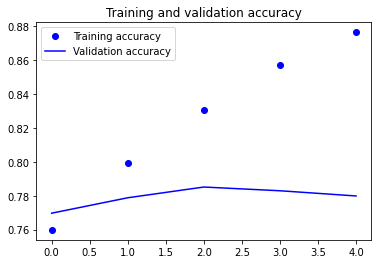

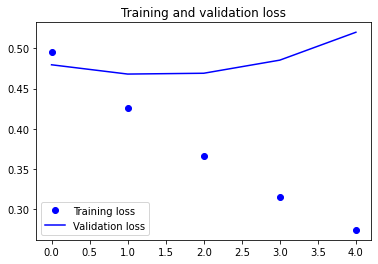

In [ ]:
run_model(model, "LSTM16", X_train, y_train, X_validation, y_validation, epochs=5)

Classification report: 
              precision    recall  f1-score   support

           0     0.8306    0.8141    0.8223     25348
           1     0.6976    0.7210    0.7091     15080

    accuracy                         0.7794     40428
   macro avg     0.7641    0.7675    0.7657     40428
weighted avg     0.7810    0.7794    0.7801     40428



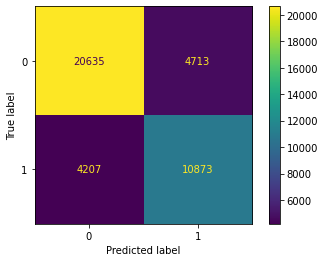

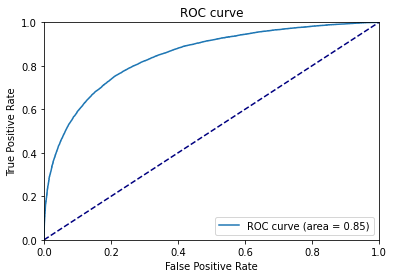

In [ ]:
evaluate_model(model, X_test, y_test)

## Experiment 2

In [ ]:
model = Sequential()
model.add(Embedding(num_distinct_words, 64))
model.add(Dropout(0.5))
model.add(layers.Bidirectional(layers.LSTM(64)))
model.add(Dense(1, activation = 'sigmoid'))

compile_model(model)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 64)          6188096   
                                                                 
 dropout_3 (Dropout)         (None, None, 64)          0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 6,254,273
Trainable params: 6,254,273
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
5053/5054 [============================>.] - ETA: 0s - loss: 0.5026 - accuracy: 0.7527
Epoch 1: val_loss improved from inf to 0.47357, saving model to /content/Models/BI_LSTM64_more_dropout.h5
5054/5054 [==============================] - 160s 32ms/step - loss: 0.5026 - accuracy: 0.7527 - val_loss: 0.4736 - val_accuracy: 0.7698
Epoch 2/10
5053/5054 [============================>.] - ETA: 0s - loss: 0.4408 - accuracy: 0.7876
Epoch 2: val_loss improved from 0.47357 to 0.45539, saving model to /content/Models/BI_LSTM64_more_dropout.h5
5054/5054 [==============================] - 153s 30ms/step - loss: 0.4408 - accuracy: 0.7876 - val_loss: 0.4554 - val_accuracy: 0.7816
Epoch 3/10
5053/5054 [============================>.] - ETA: 0s - loss: 0.4007 - accuracy: 0.8109
Epoch 3: val_loss improved from 0.45539 to 0.44500, saving model to /content/Models/BI_LSTM64_more_dropout.h5
5054/5054 [==============================] - 157s 31ms/step - loss: 0.4007 - accuracy: 0.8109 - val_loss: 0.

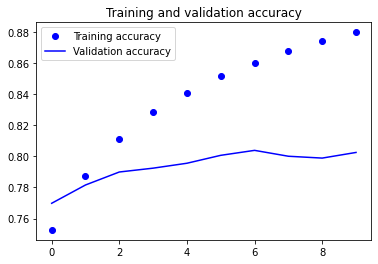

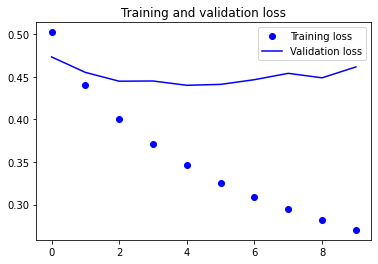

In [ ]:
run_model(model, "BI_LSTM64", X_train, y_train, X_validation, y_validation, epochs=10)

Classification report: 
              precision    recall  f1-score   support

           0     0.8588    0.8160    0.8369     25348
           1     0.7146    0.7745    0.7434     15080

    accuracy                         0.8005     40428
   macro avg     0.7867    0.7953    0.7901     40428
weighted avg     0.8050    0.8005    0.8020     40428



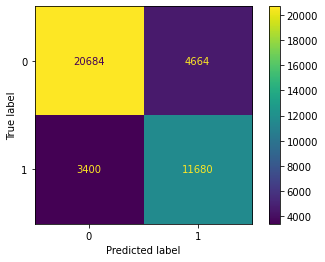

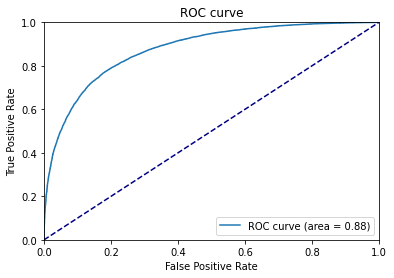

In [ ]:
evaluate_model(model, X_test, y_test)

## Experiment 3

In [ ]:
model = Sequential()
model.add(Embedding(num_distinct_words, 64))
model.add(Dropout(0.5))
model.add(layers.Bidirectional(layers.LSTM(64)))
model.add(layers.Dense(128, activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))

compile_model(model)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 64)          6188096   
                                                                 
 dropout_8 (Dropout)         (None, None, 64)          0         
                                                                 
 bidirectional_8 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 6,270,785
Trainable params: 6,270,785
Non-trainable params: 0
____________________________________________

Epoch 1/10
5053/5054 [============================>.] - ETA: 0s - loss: 0.5136 - accuracy: 0.7470
Epoch 1: val_loss improved from inf to 0.47939, saving model to /content/Models/BI_LSTM64_Dense128.h5
5054/5054 [==============================] - 160s 31ms/step - loss: 0.5136 - accuracy: 0.7470 - val_loss: 0.4794 - val_accuracy: 0.7654
Epoch 2/10
5053/5054 [============================>.] - ETA: 0s - loss: 0.4487 - accuracy: 0.7840
Epoch 2: val_loss improved from 0.47939 to 0.45630, saving model to /content/Models/BI_LSTM64_Dense128.h5
5054/5054 [==============================] - 156s 31ms/step - loss: 0.4487 - accuracy: 0.7840 - val_loss: 0.4563 - val_accuracy: 0.7818
Epoch 3/10
5053/5054 [============================>.] - ETA: 0s - loss: 0.4106 - accuracy: 0.8054
Epoch 3: val_loss improved from 0.45630 to 0.44706, saving model to /content/Models/BI_LSTM64_Dense128.h5
5054/5054 [==============================] - 152s 30ms/step - loss: 0.4106 - accuracy: 0.8054 - val_loss: 0.4471 - val_a

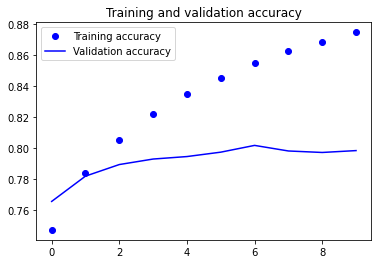

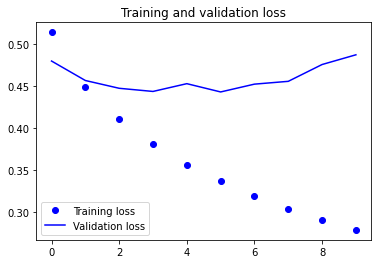

In [ ]:
run_model(model, "BI_LSTM64_Dense128", X_train, y_train, X_validation, y_validation, epochs=10)

Classification report: 
              precision    recall  f1-score   support

           0     0.8575    0.8108    0.8335     25348
           1     0.7086    0.7735    0.7397     15080

    accuracy                         0.7969     40428
   macro avg     0.7831    0.7922    0.7866     40428
weighted avg     0.8020    0.7969    0.7985     40428



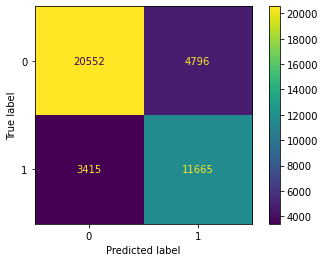

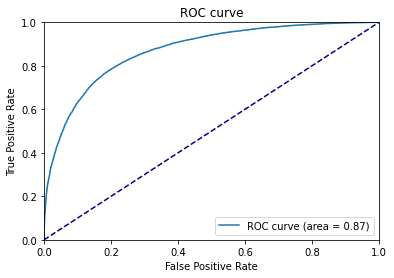

In [ ]:
evaluate_model(model, X_test, y_test)

## Experiment 4

In [ ]:
model = Sequential()
model.add(Embedding(num_distinct_words, 32))
model.add(Dropout(0.5))
model.add(layers.Bidirectional(layers.LSTM(64)))
model.add(Dense(1, activation = 'sigmoid'))

compile_model(model)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          3094048   
                                                                 
 dropout_2 (Dropout)         (None, None, 32)          0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              49664     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 3,143,841
Trainable params: 3,143,841
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
5050/5054 [============================>.] - ETA: 0s - loss: 0.5184 - accuracy: 0.7439
Epoch 1: val_loss improved from inf to 0.48457, saving model to /content/Models/BI_LSTM64_Embedding32.h5
5054/5054 [==============================] - 60s 10ms/step - loss: 0.5183 - accuracy: 0.7439 - val_loss: 0.4846 - val_accuracy: 0.7649
Epoch 2/10
5053/5054 [============================>.] - ETA: 0s - loss: 0.4610 - accuracy: 0.7779
Epoch 2: val_loss improved from 0.48457 to 0.46910, saving model to /content/Models/BI_LSTM64_Embedding32.h5
5054/5054 [==============================] - 53s 10ms/step - loss: 0.4610 - accuracy: 0.7778 - val_loss: 0.4691 - val_accuracy: 0.7737
Epoch 3/10
5051/5054 [============================>.] - ETA: 0s - loss: 0.4302 - accuracy: 0.7937
Epoch 3: val_loss improved from 0.46910 to 0.45800, saving model to /content/Models/BI_LSTM64_Embedding32.h5
5054/5054 [==============================] - 53s 11ms/step - loss: 0.4302 - accuracy: 0.7938 - val_loss: 0.4580 -

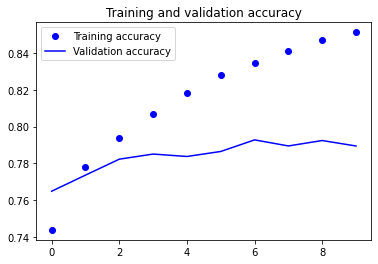

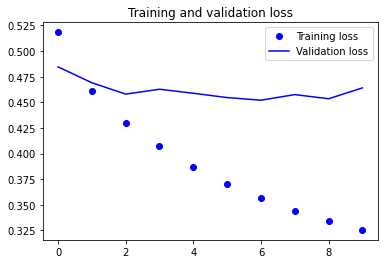

In [ ]:
run_model(model, "BI_LSTM64_Embedding32", X_train, y_train, X_validation, y_validation, epochs=10)

Classification report: 
              precision    recall  f1-score   support

           0     0.8485    0.8018    0.8245     25348
           1     0.6951    0.7593    0.7258     15080

    accuracy                         0.7860     40428
   macro avg     0.7718    0.7806    0.7751     40428
weighted avg     0.7913    0.7860    0.7877     40428



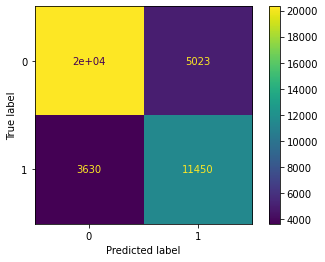

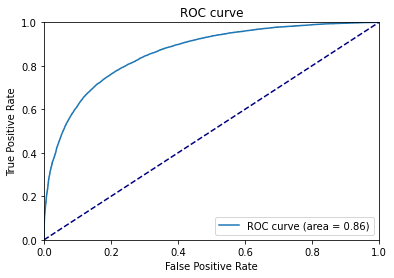

In [ ]:
evaluate_model(model, X_test, y_test)

## Experiment 5

In [ ]:
model = Sequential()
model.add(Embedding(num_distinct_words, 128))
model.add(Dropout(0.5))
model.add(layers.Bidirectional(layers.LSTM(64)))
model.add(Dense(1, activation = 'sigmoid'))

compile_model(model)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 128)         12376192  
                                                                 
 dropout_8 (Dropout)         (None, None, 128)         0         
                                                                 
 bidirectional_8 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_10 (Dense)            (None, 1)                 129       
                                                                 
Total params: 12,475,137
Trainable params: 12,475,137
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
5051/5054 [============================>.] - ETA: 0s - loss: 0.5099 - accuracy: 0.7491
Epoch 1: val_loss improved from inf to 0.46869, saving model to /content/Models/BI_LSTM64_Embedding128.h5
5054/5054 [==============================] - 83s 16ms/step - loss: 0.5099 - accuracy: 0.7492 - val_loss: 0.4687 - val_accuracy: 0.7731
Epoch 2/10
5052/5054 [============================>.] - ETA: 0s - loss: 0.4344 - accuracy: 0.7936
Epoch 2: val_loss improved from 0.46869 to 0.45150, saving model to /content/Models/BI_LSTM64_Embedding128.h5
5054/5054 [==============================] - 78s 15ms/step - loss: 0.4345 - accuracy: 0.7936 - val_loss: 0.4515 - val_accuracy: 0.7838
Epoch 3/10
5054/5054 [==============================] - ETA: 0s - loss: 0.3869 - accuracy: 0.8205
Epoch 3: val_loss improved from 0.45150 to 0.44885, saving model to /content/Models/BI_LSTM64_Embedding128.h5
5054/5054 [==============================] - 77s 15ms/step - loss: 0.3869 - accuracy: 0.8205 - val_loss: 0.448

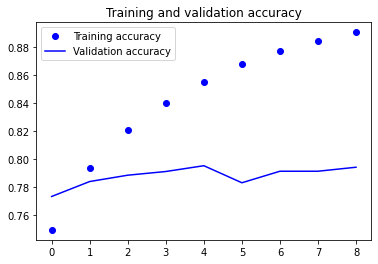

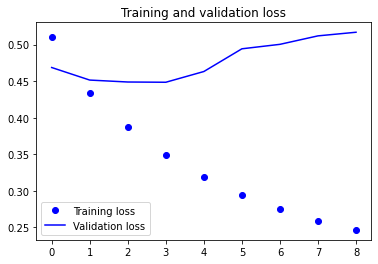

In [ ]:
run_model(model, "BI_LSTM64_Embedding128", X_train, y_train, X_validation, y_validation, epochs=10)

Classification report: 
              precision    recall  f1-score   support

           0     0.8389    0.8155    0.8270     25348
           1     0.7038    0.7368    0.7199     15080

    accuracy                         0.7861     40428
   macro avg     0.7713    0.7761    0.7735     40428
weighted avg     0.7885    0.7861    0.7871     40428



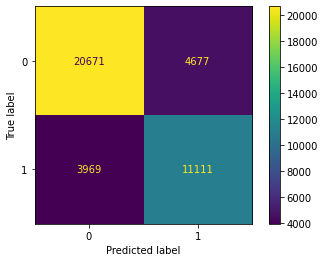

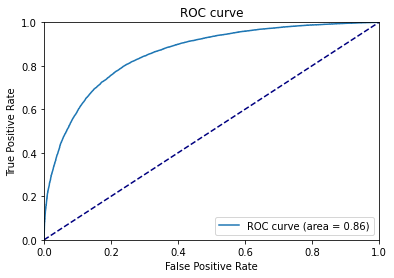

In [ ]:
evaluate_model(model, X_test, y_test)

## Experiment 6

In [ ]:
model = Sequential()
model.add(Embedding(num_distinct_words, 64))
model.add(Dropout(0.5))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(Dense(1, activation = 'sigmoid'))

compile_model(model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          6188096   
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 64)               24832     
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 6,212,993
Trainable params: 6,212,993
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
5054/5054 [==============================] - ETA: 0s - loss: 0.5147 - accuracy: 0.7455
Epoch 1: val_loss improved from inf to 0.48247, saving model to /content/Models/BI_LSTM32.h5
5054/5054 [==============================] - 158s 30ms/step - loss: 0.5147 - accuracy: 0.7455 - val_loss: 0.4825 - val_accuracy: 0.7679
Epoch 2/10
5053/5054 [============================>.] - ETA: 0s - loss: 0.4480 - accuracy: 0.7846
Epoch 2: val_loss improved from 0.48247 to 0.45848, saving model to /content/Models/BI_LSTM32.h5
5054/5054 [==============================] - 148s 29ms/step - loss: 0.4480 - accuracy: 0.7846 - val_loss: 0.4585 - val_accuracy: 0.7808
Epoch 3/10
5053/5054 [============================>.] - ETA: 0s - loss: 0.4101 - accuracy: 0.8044
Epoch 3: val_loss improved from 0.45848 to 0.45071, saving model to /content/Models/BI_LSTM32.h5
5054/5054 [==============================] - 148s 29ms/step - loss: 0.4101 - accuracy: 0.8044 - val_loss: 0.4507 - val_accuracy: 0.7874
Epoch 4/10


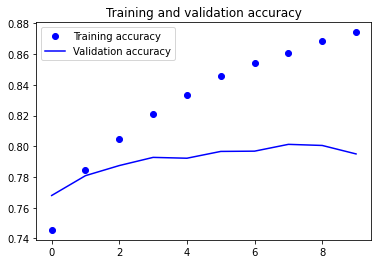

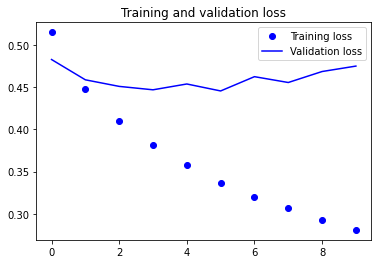

In [ ]:
run_model(model, "BI_LSTM32", X_train, y_train, X_validation, y_validation, epochs=10)

Classification report: 
              precision    recall  f1-score   support

           0     0.8604    0.8021    0.8302     25348
           1     0.7013    0.7812    0.7391     15080

    accuracy                         0.7943     40428
   macro avg     0.7808    0.7916    0.7846     40428
weighted avg     0.8010    0.7943    0.7962     40428



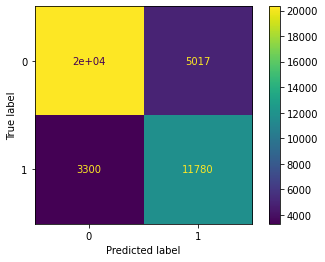

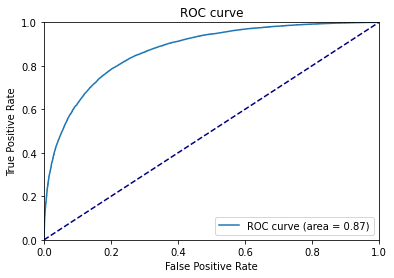

In [ ]:
evaluate_model(model, X_test, y_test)

## Experiment 7

In [ ]:
model = Sequential()
model.add(Embedding(num_distinct_words, 32))
model.add(Dropout(0.5))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(Dense(1, activation = 'sigmoid'))

compile_model(model)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          3094048   
                                                                 
 dropout_1 (Dropout)         (None, None, 32)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 3,110,753
Trainable params: 3,110,753
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
5052/5054 [============================>.] - ETA: 0s - loss: 0.5180 - accuracy: 0.7442
Epoch 1: val_loss improved from inf to 0.48528, saving model to /content/Models/BI_LSTM32_Embedding32.h5
5054/5054 [==============================] - 135s 26ms/step - loss: 0.5180 - accuracy: 0.7442 - val_loss: 0.4853 - val_accuracy: 0.7645
Epoch 2/10
5053/5054 [============================>.] - ETA: 0s - loss: 0.4602 - accuracy: 0.7776
Epoch 2: val_loss improved from 0.48528 to 0.46838, saving model to /content/Models/BI_LSTM32_Embedding32.h5
5054/5054 [==============================] - 130s 26ms/step - loss: 0.4602 - accuracy: 0.7776 - val_loss: 0.4684 - val_accuracy: 0.7713
Epoch 3/10
5053/5054 [============================>.] - ETA: 0s - loss: 0.4303 - accuracy: 0.7936
Epoch 3: val_loss improved from 0.46838 to 0.45548, saving model to /content/Models/BI_LSTM32_Embedding32.h5
5054/5054 [==============================] - 130s 26ms/step - loss: 0.4303 - accuracy: 0.7936 - val_loss: 0.455

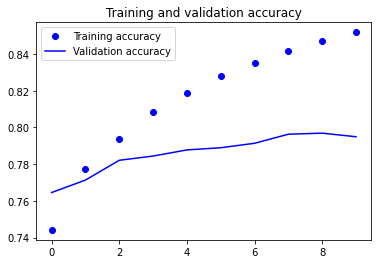

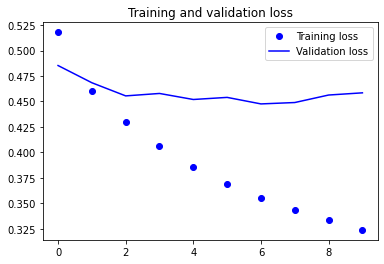

In [ ]:
run_model(model, "BI_LSTM32_Embedding32", X_train, y_train, X_validation, y_validation, epochs=10)

Classification report: 
              precision    recall  f1-score   support

           0     0.8529    0.8071    0.8294     25348
           1     0.7026    0.7661    0.7330     15080

    accuracy                         0.7918     40428
   macro avg     0.7778    0.7866    0.7812     40428
weighted avg     0.7969    0.7918    0.7934     40428



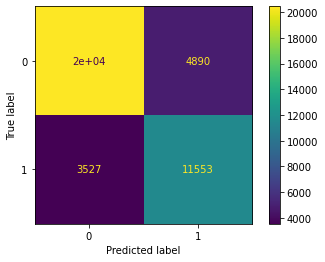

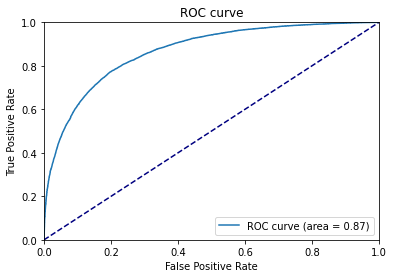

In [ ]:
evaluate_model(model, X_test, y_test)

## Experiment 8

In [ ]:
model = Sequential()
model.add(Embedding(num_distinct_words, 16))
model.add(Dropout(0.5))
model.add(layers.Bidirectional(layers.LSTM(64)))
model.add(Dense(1, activation = 'sigmoid'))

compile_model(model)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          1547024   
                                                                 
 dropout_1 (Dropout)         (None, None, 16)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              41472     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,588,625
Trainable params: 1,588,625
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
5053/5054 [============================>.] - ETA: 0s - loss: 0.5247 - accuracy: 0.7402
Epoch 1: val_loss improved from inf to 0.49089, saving model to /content/Models/BI_LSTM64_embedding16.h5
5054/5054 [==============================] - 153s 29ms/step - loss: 0.5247 - accuracy: 0.7403 - val_loss: 0.4909 - val_accuracy: 0.7639
Epoch 2/10
5053/5054 [============================>.] - ETA: 0s - loss: 0.4700 - accuracy: 0.7745
Epoch 2: val_loss improved from 0.49089 to 0.47358, saving model to /content/Models/BI_LSTM64_embedding16.h5
5054/5054 [==============================] - 145s 29ms/step - loss: 0.4700 - accuracy: 0.7744 - val_loss: 0.4736 - val_accuracy: 0.7675
Epoch 3/10
5054/5054 [==============================] - ETA: 0s - loss: 0.4455 - accuracy: 0.7865
Epoch 3: val_loss improved from 0.47358 to 0.47331, saving model to /content/Models/BI_LSTM64_embedding16.h5
5054/5054 [==============================] - 145s 29ms/step - loss: 0.4455 - accuracy: 0.7865 - val_loss: 0.473

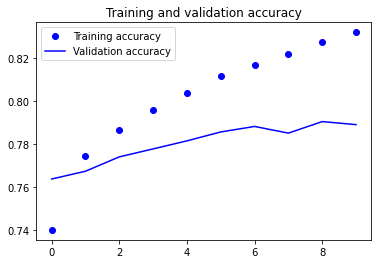

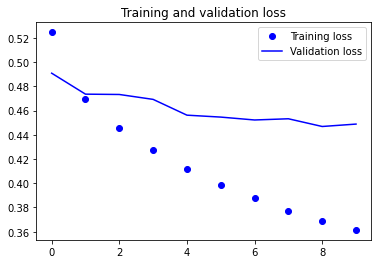

In [ ]:
run_model(model, "BI_LSTM64_embedding16", X_train, y_train, X_validation, y_validation, epochs=10)

Classification report: 
              precision    recall  f1-score   support

           0     0.8364    0.8174    0.8268     25348
           1     0.7044    0.7313    0.7176     15080

    accuracy                         0.7853     40428
   macro avg     0.7704    0.7744    0.7722     40428
weighted avg     0.7872    0.7853    0.7861     40428



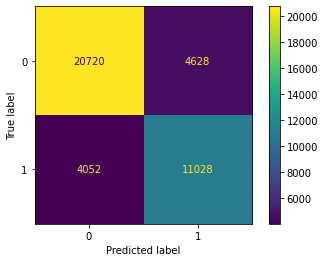

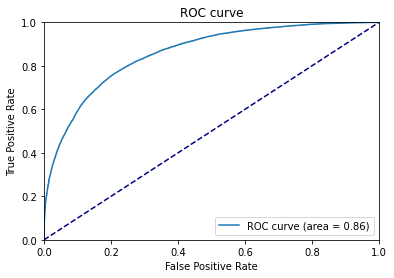

In [ ]:
evaluate_model(model, X_test, y_test)

## Class weight

### Experiment 1

In [ ]:
model = Sequential()
model.add(Embedding(num_distinct_words, 64))
model.add(Dropout(0.5))
model.add(layers.Bidirectional(layers.LSTM(64)))
model.add(Dense(1, activation = 'sigmoid'))

compile_model(model)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 64)          6188096   
                                                                 
 dropout_6 (Dropout)         (None, None, 64)          0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 6,254,273
Trainable params: 6,254,273
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
5053/5054 [============================>.] - ETA: 0s - loss: 0.5347 - accuracy: 0.7277
Epoch 1: val_loss improved from inf to 0.49670, saving model to /content/Models/BI_LSTM64_weights.h5
5054/5054 [==============================] - 63s 12ms/step - loss: 0.5347 - accuracy: 0.7277 - val_loss: 0.4967 - val_accuracy: 0.7511
Epoch 2/10
5050/5054 [============================>.] - ETA: 0s - loss: 0.4635 - accuracy: 0.7727
Epoch 2: val_loss improved from 0.49670 to 0.47433, saving model to /content/Models/BI_LSTM64_weights.h5
5054/5054 [==============================] - 59s 12ms/step - loss: 0.4635 - accuracy: 0.7727 - val_loss: 0.4743 - val_accuracy: 0.7737
Epoch 3/10
5053/5054 [============================>.] - ETA: 0s - loss: 0.4195 - accuracy: 0.7975
Epoch 3: val_loss did not improve from 0.47433
5054/5054 [==============================] - 59s 12ms/step - loss: 0.4195 - accuracy: 0.7975 - val_loss: 0.4744 - val_accuracy: 0.7691
Epoch 4/10
5053/5054 [==========================

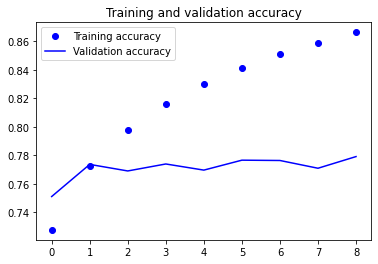

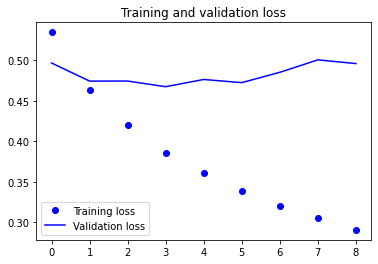

In [ ]:
run_model(model, "BI_LSTM64_weights", X_train, y_train, X_validation, y_validation, epochs=10, class_weight=class_weights)

Classification report: 
              precision    recall  f1-score   support

           0     0.8754    0.7495    0.8075     25348
           1     0.6609    0.8206    0.7321     15080

    accuracy                         0.7760     40428
   macro avg     0.7681    0.7851    0.7698     40428
weighted avg     0.7954    0.7760    0.7794     40428



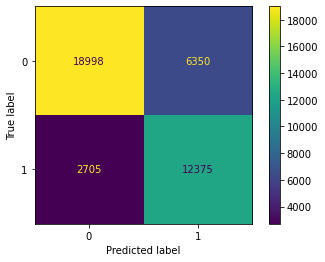

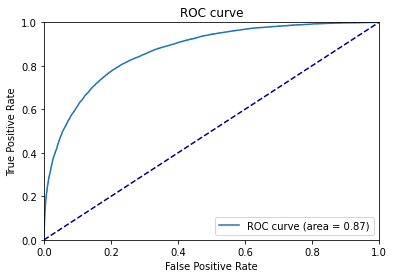

In [ ]:
evaluate_model(model, X_test, y_test)

### Experiment 2

In [ ]:
model = Sequential()
model.add(Embedding(num_distinct_words, 64))
model.add(layers.Bidirectional(layers.LSTM(64)))
model.add(layers.Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

compile_model(model)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          6188096   
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 6,270,785
Trainable params: 6,270,785
Non-trainable params: 0
____________________________________________

Epoch 1/10
5053/5054 [============================>.] - ETA: 0s - loss: 0.5264 - accuracy: 0.7352
Epoch 1: val_loss improved from inf to 0.49831, saving model to /content/Models/BI_LSTM64_Dense128_weights.h5
5054/5054 [==============================] - 64s 12ms/step - loss: 0.5264 - accuracy: 0.7352 - val_loss: 0.4983 - val_accuracy: 0.7585
Epoch 2/10
5051/5054 [============================>.] - ETA: 0s - loss: 0.4140 - accuracy: 0.8037
Epoch 2: val_loss improved from 0.49831 to 0.46367, saving model to /content/Models/BI_LSTM64_Dense128_weights.h5
5054/5054 [==============================] - 60s 12ms/step - loss: 0.4140 - accuracy: 0.8037 - val_loss: 0.4637 - val_accuracy: 0.7742
Epoch 3/10
5051/5054 [============================>.] - ETA: 0s - loss: 0.3296 - accuracy: 0.8490
Epoch 3: val_loss did not improve from 0.46367
5054/5054 [==============================] - 60s 12ms/step - loss: 0.3296 - accuracy: 0.8489 - val_loss: 0.4700 - val_accuracy: 0.7916
Epoch 4/10
5054/5054 [========

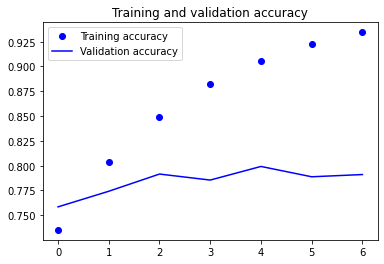

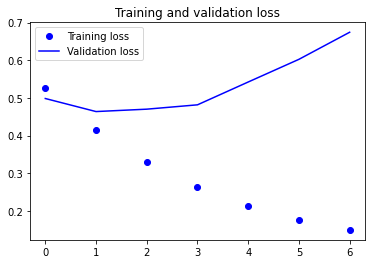

In [ ]:
run_model(model, "BI_LSTM64_Dense128_weights", X_train, y_train, X_validation, y_validation, epochs=10, class_weight=class_weights)

Classification report: 
              precision    recall  f1-score   support

           0     0.8788    0.7737    0.8229     25348
           1     0.6833    0.8206    0.7456     15080

    accuracy                         0.7912     40428
   macro avg     0.7810    0.7971    0.7843     40428
weighted avg     0.8058    0.7912    0.7941     40428



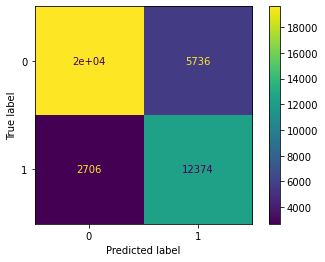

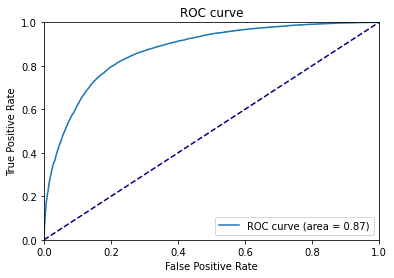

In [ ]:
evaluate_model(model, X_test, y_test)

### Experiment 3

In [ ]:
model = Sequential()
model.add(Embedding(num_distinct_words, 32))
model.add(Dropout(0.5))
model.add(layers.Bidirectional(layers.LSTM(64)))
model.add(Dense(1, activation = 'sigmoid'))

compile_model(model)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 32)          3094048   
                                                                 
 dropout_5 (Dropout)         (None, None, 32)          0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              49664     
 nal)                                                            
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 3,143,841
Trainable params: 3,143,841
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
5052/5054 [============================>.] - ETA: 0s - loss: 0.5420 - accuracy: 0.7241
Epoch 1: val_loss improved from inf to 0.50344, saving model to /content/Models/BI_LSTM64_Embedding32_weights.h5
5054/5054 [==============================] - 56s 11ms/step - loss: 0.5420 - accuracy: 0.7241 - val_loss: 0.5034 - val_accuracy: 0.7544
Epoch 2/10
5052/5054 [============================>.] - ETA: 0s - loss: 0.4775 - accuracy: 0.7667
Epoch 2: val_loss improved from 0.50344 to 0.49768, saving model to /content/Models/BI_LSTM64_Embedding32_weights.h5
5054/5054 [==============================] - 52s 10ms/step - loss: 0.4775 - accuracy: 0.7667 - val_loss: 0.4977 - val_accuracy: 0.7543
Epoch 3/10
5052/5054 [============================>.] - ETA: 0s - loss: 0.4423 - accuracy: 0.7856
Epoch 3: val_loss improved from 0.49768 to 0.49008, saving model to /content/Models/BI_LSTM64_Embedding32_weights.h5
5054/5054 [==============================] - 52s 10ms/step - loss: 0.4423 - accuracy: 0.7

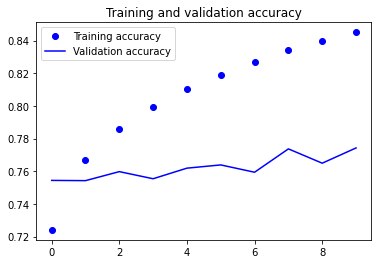

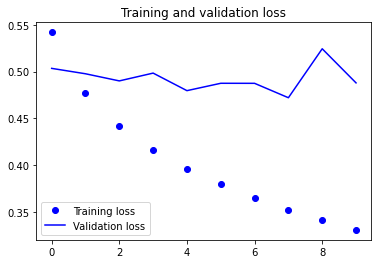

In [ ]:
run_model(model, "BI_LSTM64_Embedding32_weights", X_train, y_train, X_validation, y_validation, epochs=10, class_weight=class_weights)

Classification report: 
              precision    recall  f1-score   support

           0     0.8748    0.7394    0.8014     25348
           1     0.6524    0.8221    0.7275     15080

    accuracy                         0.7702     40428
   macro avg     0.7636    0.7807    0.7644     40428
weighted avg     0.7918    0.7702    0.7738     40428



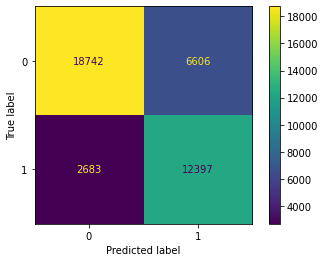

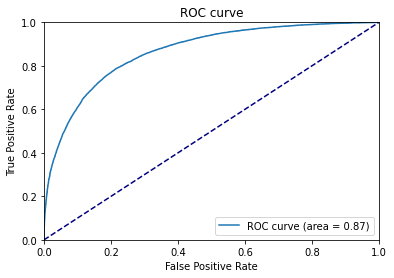

In [ ]:
evaluate_model(model, X_test, y_test)

### Experiment 4

In [ ]:
model = Sequential()
model.add(Embedding(num_distinct_words, 128))
model.add(Dropout(0.5))
model.add(layers.Bidirectional(layers.LSTM(64)))
model.add(Dense(1, activation = 'sigmoid'))

compile_model(model)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 128)         12376192  
                                                                 
 dropout_9 (Dropout)         (None, None, 128)         0         
                                                                 
 bidirectional_9 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 12,475,137
Trainable params: 12,475,137
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
5052/5054 [============================>.] - ETA: 0s - loss: 0.5313 - accuracy: 0.7303
Epoch 1: val_loss improved from inf to 0.49470, saving model to /content/Models/BI_LSTM64_Embedding128_weights.h5
5054/5054 [==============================] - 91s 17ms/step - loss: 0.5313 - accuracy: 0.7303 - val_loss: 0.4947 - val_accuracy: 0.7540
Epoch 2/10
5053/5054 [============================>.] - ETA: 0s - loss: 0.4488 - accuracy: 0.7815
Epoch 2: val_loss improved from 0.49470 to 0.48714, saving model to /content/Models/BI_LSTM64_Embedding128_weights.h5
5054/5054 [==============================] - 82s 16ms/step - loss: 0.4488 - accuracy: 0.7815 - val_loss: 0.4871 - val_accuracy: 0.7564
Epoch 3/10
5053/5054 [============================>.] - ETA: 0s - loss: 0.3952 - accuracy: 0.8112
Epoch 3: val_loss improved from 0.48714 to 0.47384, saving model to /content/Models/BI_LSTM64_Embedding128_weights.h5
5054/5054 [==============================] - 81s 16ms/step - loss: 0.3952 - accuracy: 

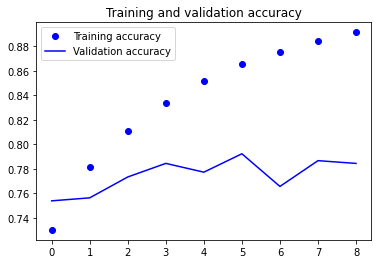

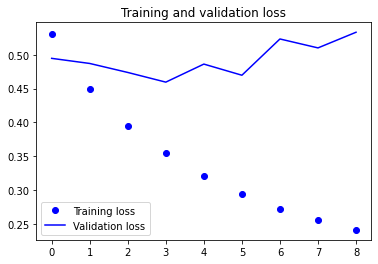

In [ ]:
run_model(model, "BI_LSTM64_Embedding128_weights", X_train, y_train, X_validation, y_validation, epochs=10, class_weight=class_weights)

Classification report: 
              precision    recall  f1-score   support

           0     0.8804    0.7587    0.8150     25348
           1     0.6709    0.8268    0.7407     15080

    accuracy                         0.7841     40428
   macro avg     0.7756    0.7927    0.7779     40428
weighted avg     0.8023    0.7841    0.7873     40428



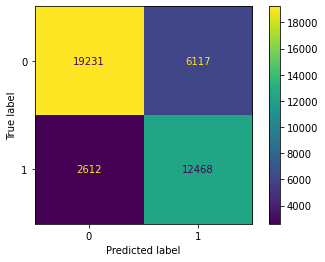

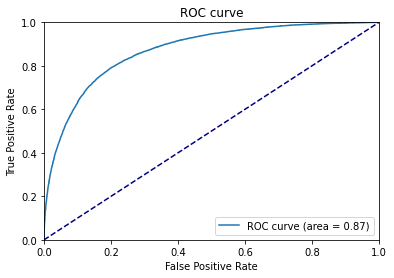

In [ ]:
evaluate_model(model, X_test, y_test)

## Attention

### Experiment 1

In [ ]:
model = Sequential()
model.add(Embedding(num_distinct_words, 64))
model.add(Dropout(0.5))
model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True)))
model.add(Attention(32))
model.add(Dense(1, activation = 'sigmoid'))

compile_model(model)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          6188096   
                                                                 
 dropout_1 (Dropout)         (None, None, 64)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 attention_1 (Attention)     (None, 32)                24576     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 6,278,753
Trainable params: 6,278,753
Non-trainable params: 0
____________________________________________

Epoch 1/10
5054/5054 [==============================] - ETA: 0s - loss: 0.5159 - accuracy: 0.7437
Epoch 1: val_loss improved from inf to 0.49115, saving model to /content/Models/BI_LSTM64_Attention32.h5
5054/5054 [==============================] - 183s 34ms/step - loss: 0.5159 - accuracy: 0.7437 - val_loss: 0.4911 - val_accuracy: 0.7621
Epoch 2/10
5054/5054 [==============================] - ETA: 0s - loss: 0.4578 - accuracy: 0.7787
Epoch 2: val_loss improved from 0.49115 to 0.47017, saving model to /content/Models/BI_LSTM64_Attention32.h5
5054/5054 [==============================] - 172s 34ms/step - loss: 0.4578 - accuracy: 0.7787 - val_loss: 0.4702 - val_accuracy: 0.7715
Epoch 3/10
5054/5054 [==============================] - ETA: 0s - loss: 0.4250 - accuracy: 0.7957
Epoch 3: val_loss improved from 0.47017 to 0.45957, saving model to /content/Models/BI_LSTM64_Attention32.h5
5054/5054 [==============================] - 171s 34ms/step - loss: 0.4250 - accuracy: 0.7957 - val_loss: 0.459

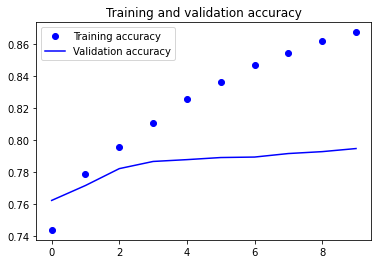

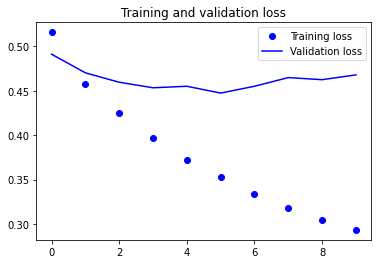

In [ ]:
run_model(model, "BI_LSTM64_Attention32", X_train, y_train, X_validation, y_validation, epochs=10)

Classification report: 
              precision    recall  f1-score   support

           0     0.8477    0.8155    0.8313     25348
           1     0.7085    0.7537    0.7304     15080

    accuracy                         0.7925     40428
   macro avg     0.7781    0.7846    0.7809     40428
weighted avg     0.7958    0.7925    0.7937     40428



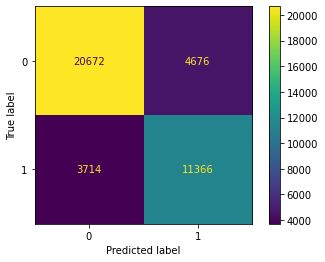

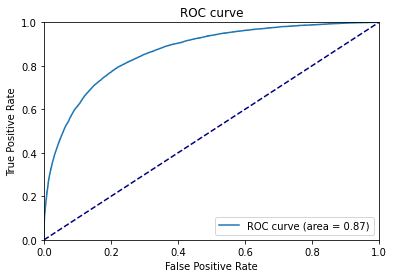

In [ ]:
evaluate_model(model, X_test, y_test)

### Experiment 2

In [ ]:
model = Sequential()
model.add(Embedding(num_distinct_words, 64))
model.add(Dropout(0.5))
model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True)))
model.add(Attention(32))
model.add(Dense(1, activation = 'sigmoid'))

compile_model(model)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 64)          6188096   
                                                                 
 dropout_4 (Dropout)         (None, None, 64)          0         
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 attention_4 (Attention)     (None, 32)                24576     
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6,278,753
Trainable params: 6,278,753
Non-trainable params: 0
____________________________________________

Epoch 1/10
5054/5054 [==============================] - ETA: 0s - loss: 0.5392 - accuracy: 0.7214
Epoch 1: val_loss improved from inf to 0.52066, saving model to /content/Models/BI_LSTM64_Attention32_weights.h5
5054/5054 [==============================] - 176s 34ms/step - loss: 0.5392 - accuracy: 0.7214 - val_loss: 0.5207 - val_accuracy: 0.7390
Epoch 2/10
5053/5054 [============================>.] - ETA: 0s - loss: 0.4752 - accuracy: 0.7626
Epoch 2: val_loss improved from 0.52066 to 0.48015, saving model to /content/Models/BI_LSTM64_Attention32_weights.h5
5054/5054 [==============================] - 174s 34ms/step - loss: 0.4752 - accuracy: 0.7626 - val_loss: 0.4802 - val_accuracy: 0.7642
Epoch 3/10
5054/5054 [==============================] - ETA: 0s - loss: 0.4391 - accuracy: 0.7827
Epoch 3: val_loss did not improve from 0.48015
5054/5054 [==============================] - 174s 34ms/step - loss: 0.4391 - accuracy: 0.7827 - val_loss: 0.4944 - val_accuracy: 0.7585
Epoch 4/10
5054/5054 

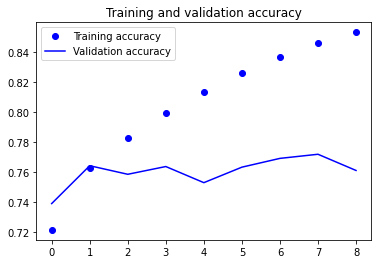

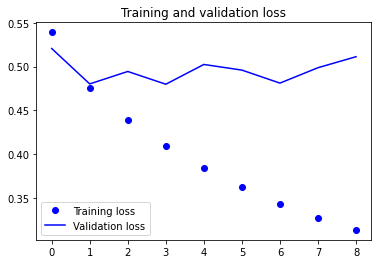

In [ ]:
run_model(model, "BI_LSTM64_Attention32_weights", X_train, y_train, X_validation, y_validation, epochs=10, class_weight=class_weights)

Classification report: 
              precision    recall  f1-score   support

           0     0.8820    0.7163    0.7905     25348
           1     0.6375    0.8389    0.7245     15080

    accuracy                         0.7620     40428
   macro avg     0.7597    0.7776    0.7575     40428
weighted avg     0.7908    0.7620    0.7659     40428



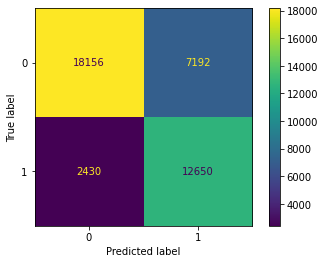

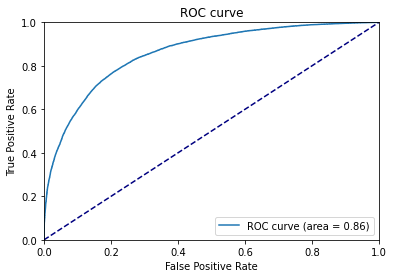

In [ ]:
evaluate_model(model, X_test, y_test)

### Experiment 3

In [ ]:
model = Sequential()
model.add(Embedding(num_distinct_words, 64))
model.add(Dropout(0.5))
model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True)))
model.add(Attention())
model.add(Dense(1, activation = 'sigmoid'))

compile_model(model)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 64)          6188096   
                                                                 
 dropout_4 (Dropout)         (None, None, 64)          0         
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 64)         24832     
 nal)                                                            
                                                                 
 attention_1 (Attention)     (None, 128)               20480     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 6,233,537
Trainable params: 6,233,537
Non-trainable params: 0
____________________________________________

Epoch 1/10
5054/5054 [==============================] - ETA: 0s - loss: 0.5128 - accuracy: 0.7461
Epoch 1: val_loss improved from inf to 0.47891, saving model to /content/Models/BI_LSTM32_attention.h5
5054/5054 [==============================] - 162s 31ms/step - loss: 0.5128 - accuracy: 0.7461 - val_loss: 0.4789 - val_accuracy: 0.7633
Epoch 2/10
5054/5054 [==============================] - ETA: 0s - loss: 0.4533 - accuracy: 0.7801
Epoch 2: val_loss improved from 0.47891 to 0.46736, saving model to /content/Models/BI_LSTM32_attention.h5
5054/5054 [==============================] - 155s 31ms/step - loss: 0.4533 - accuracy: 0.7801 - val_loss: 0.4674 - val_accuracy: 0.7750
Epoch 3/10
5054/5054 [==============================] - ETA: 0s - loss: 0.4190 - accuracy: 0.7982
Epoch 3: val_loss improved from 0.46736 to 0.46147, saving model to /content/Models/BI_LSTM32_attention.h5
5054/5054 [==============================] - 155s 31ms/step - loss: 0.4190 - accuracy: 0.7982 - val_loss: 0.4615 - va

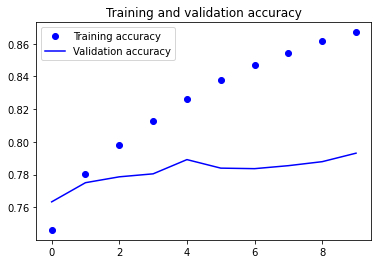

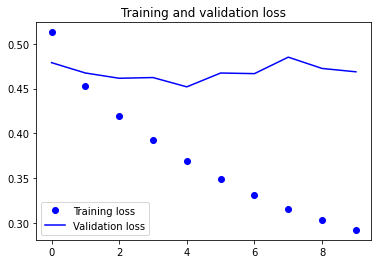

In [ ]:
run_model(model, "BI_LSTM32_attention", X_train, y_train, X_validation, y_validation, epochs=10)

Classification report: 
              precision    recall  f1-score   support

           0     0.8327    0.8388    0.8358     25348
           1     0.7257    0.7168    0.7212     15080

    accuracy                         0.7933     40428
   macro avg     0.7792    0.7778    0.7785     40428
weighted avg     0.7928    0.7933    0.7930     40428



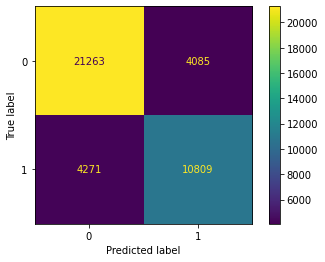

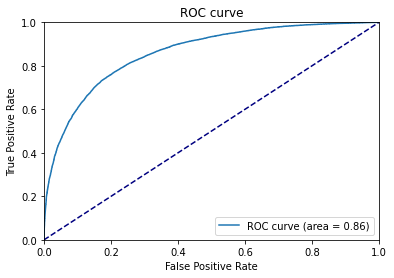

In [ ]:
evaluate_model(model, X_test, y_test)

# Data Augmentation for class balancing
It is possible to increase the number of elements of class 1, just swapping the two questions q1 and q2.

In [ ]:
counts = train_questions['is_duplicate'].value_counts()
counts

0    204207
1    119224
Name: is_duplicate, dtype: int64

In [ ]:
support_duplicate = counts[1]
support_no_duplicate = counts[0]
needed_to_balance = support_no_duplicate - support_duplicate

augmented_train_questions = train_questions
duplicate_train_questions = train_questions[train_questions['is_duplicate'] == 1]

# Take samples from the class 'is_duplicate' and add to augmented_train_questions
samples = duplicate_train_questions.sample(n=needed_to_balance, replace=False)
# We need to swap the two questions to get a new tokenizer
samples = samples.rename(columns={"qid1": "qid2", 
                        "qid2": "qid1", 
                        "question1": "question2", 
                        "question2": "question1", 
                        "question1_cleaned": "question2_cleaned", 
                        "question2_cleaned": "question1_cleaned",
                        "tokenizer_1": "tokenizer_2", 
                        "tokenizer_2": "tokenizer_1"})
samples['tokenizer'] = samples['tokenizer_1'] + samples['tokenizer_2']

augmented_train_questions = pd.concat([augmented_train_questions, samples], ignore_index=True)

In [ ]:
augmented_train_questions['is_duplicate'].value_counts()

0    204207
1    204207
Name: is_duplicate, dtype: int64

In [ ]:
y_train_augmented = augmented_train_questions[['is_duplicate']]
X_train_augmented = augmented_train_questions[['tokenizer']]
X_train_augmented = sequence.pad_sequences(X_train_augmented.tokenizer, maxlen = m_len, padding='post', truncating='post')

## Experiment 1

In [ ]:
model = Sequential()
model.add(Embedding(num_distinct_words, 64))
model.add(Dropout(0.5))
model.add(layers.Bidirectional(layers.LSTM(64)))
model.add(Dense(1, activation = 'sigmoid'))

compile_model(model)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          6188096   
                                                                 
 dropout_1 (Dropout)         (None, None, 64)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 6,254,273
Trainable params: 6,254,273
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
6382/6382 [==============================] - ETA: 0s - loss: 0.5190 - accuracy: 0.7376
Epoch 1: val_loss improved from inf to 0.48470, saving model to /content/Models/BI_LSTM64_augmentation.h5
6382/6382 [==============================] - 224s 34ms/step - loss: 0.5190 - accuracy: 0.7376 - val_loss: 0.4847 - val_accuracy: 0.7629
Epoch 2/10
6381/6382 [============================>.] - ETA: 0s - loss: 0.4383 - accuracy: 0.7931
Epoch 2: val_loss did not improve from 0.48470
6382/6382 [==============================] - 215s 34ms/step - loss: 0.4383 - accuracy: 0.7931 - val_loss: 0.4860 - val_accuracy: 0.7657
Epoch 3/10
6381/6382 [============================>.] - ETA: 0s - loss: 0.3907 - accuracy: 0.8218
Epoch 3: val_loss improved from 0.48470 to 0.46395, saving model to /content/Models/BI_LSTM64_augmentation.h5
6382/6382 [==============================] - 211s 33ms/step - loss: 0.3907 - accuracy: 0.8218 - val_loss: 0.4640 - val_accuracy: 0.7812
Epoch 4/10
6381/6382 [=============

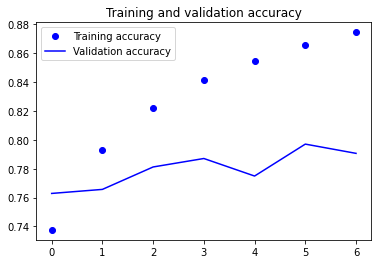

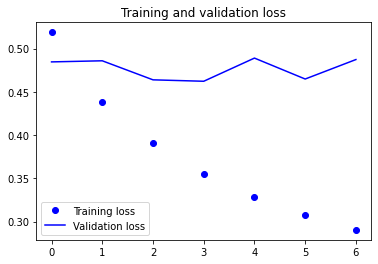

In [ ]:
run_model(model, "BI_LSTM64_augmentation", X_train_augmented, y_train_augmented, X_validation, y_validation, epochs=10, patience=3)

Classification report: 
              precision    recall  f1-score   support

           0     0.8792    0.7709    0.8215     25348
           1     0.6810    0.8220    0.7449     15080

    accuracy                         0.7900     40428
   macro avg     0.7801    0.7965    0.7832     40428
weighted avg     0.8053    0.7900    0.7930     40428



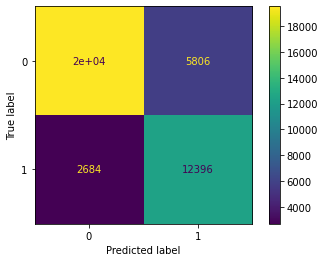

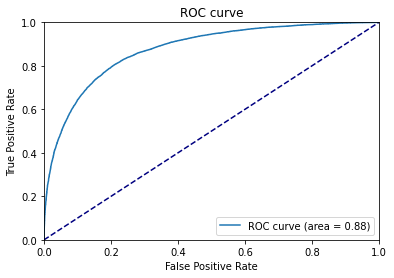

In [ ]:
evaluate_model(model, X_test, y_test)

## Experiment 2 

In [ ]:
model = Sequential()
model.add(Embedding(num_distinct_words, 64))
model.add(Dropout(0.5))
model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True)))
model.add(Attention())
model.add(Dense(1, activation = 'sigmoid'))

compile_model(model)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 64)          6188096   
                                                                 
 dropout_3 (Dropout)         (None, None, 64)          0         
                                                                 
 bidirectional_3 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 attention (Attention)       (None, 128)               49152     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 6,303,425
Trainable params: 6,303,425
Non-trainable params: 0
____________________________________________

Epoch 1/10
6382/6382 [==============================] - ETA: 0s - loss: 0.5234 - accuracy: 0.7322
Epoch 1: val_loss improved from inf to 0.52023, saving model to /content/Models/BI_LSTM64_attention_augmentation.h5
6382/6382 [==============================] - 217s 33ms/step - loss: 0.5234 - accuracy: 0.7322 - val_loss: 0.5202 - val_accuracy: 0.7428
Epoch 2/10
6382/6382 [==============================] - ETA: 0s - loss: 0.4497 - accuracy: 0.7837
Epoch 2: val_loss improved from 0.52023 to 0.49132, saving model to /content/Models/BI_LSTM64_attention_augmentation.h5
6382/6382 [==============================] - 209s 33ms/step - loss: 0.4497 - accuracy: 0.7837 - val_loss: 0.4913 - val_accuracy: 0.7565
Epoch 3/10
6381/6382 [============================>.] - ETA: 0s - loss: 0.4023 - accuracy: 0.8136
Epoch 3: val_loss improved from 0.49132 to 0.48189, saving model to /content/Models/BI_LSTM64_attention_augmentation.h5
6382/6382 [==============================] - 210s 33ms/step - loss: 0.4023 - a

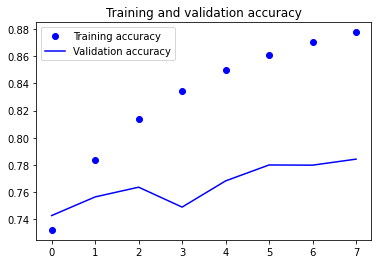

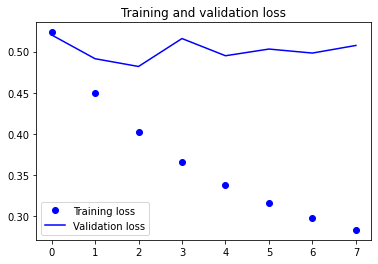

In [ ]:
run_model(model, "BI_LSTM64_attention_augmentation", X_train_augmented, y_train_augmented, X_validation, y_validation, epochs=10)

Classification report: 
              precision    recall  f1-score   support

           0     0.8692    0.7733    0.8185     25348
           1     0.6786    0.8044    0.7362     15080

    accuracy                         0.7849     40428
   macro avg     0.7739    0.7889    0.7773     40428
weighted avg     0.7981    0.7849    0.7878     40428



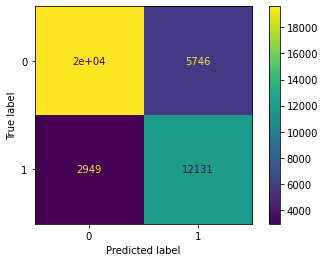

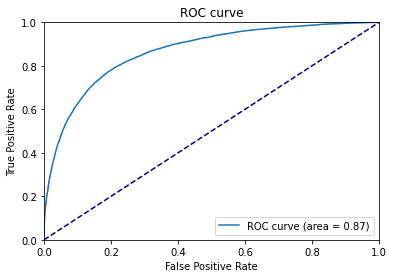

In [ ]:
evaluate_model(model, X_test, y_test)

## Experiment 3

In [ ]:
model = Sequential()
model.add(Embedding(num_distinct_words, 32))
model.add(Dropout(0.5))
model.add(layers.Bidirectional(layers.LSTM(64)))
model.add(Dense(1, activation = 'sigmoid'))

compile_model(model)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          3094048   
                                                                 
 dropout_2 (Dropout)         (None, None, 32)          0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              49664     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 3,143,841
Trainable params: 3,143,841
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
6381/6382 [============================>.] - ETA: 0s - loss: 0.5302 - accuracy: 0.7308
Epoch 1: val_loss improved from inf to 0.53253, saving model to /content/Models/BI_LSTM64_Embedding32_augmented.h5
6382/6382 [==============================] - 208s 31ms/step - loss: 0.5303 - accuracy: 0.7308 - val_loss: 0.5325 - val_accuracy: 0.7205
Epoch 2/10
6381/6382 [============================>.] - ETA: 0s - loss: 0.4601 - accuracy: 0.7800
Epoch 2: val_loss improved from 0.53253 to 0.47226, saving model to /content/Models/BI_LSTM64_Embedding32_augmented.h5
6382/6382 [==============================] - 198s 31ms/step - loss: 0.4601 - accuracy: 0.7800 - val_loss: 0.4723 - val_accuracy: 0.7663
Epoch 3/10
6381/6382 [============================>.] - ETA: 0s - loss: 0.4222 - accuracy: 0.8027
Epoch 3: val_loss did not improve from 0.47226
6382/6382 [==============================] - 196s 31ms/step - loss: 0.4222 - accuracy: 0.8027 - val_loss: 0.4884 - val_accuracy: 0.7596
Epoch 4/10
6381/6

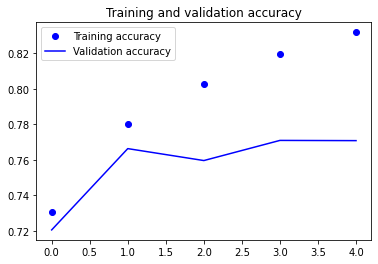

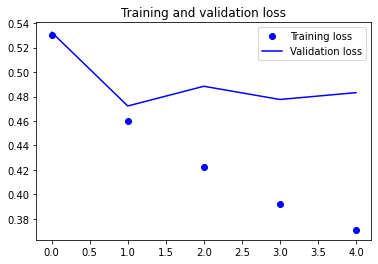

In [ ]:
run_model(model, "BI_LSTM64_Embedding32_augmented", X_train_augmented, y_train_augmented, X_validation, y_validation, epochs=10, patience=3)

Classification report: 
              precision    recall  f1-score   support

           0     0.8671    0.7468    0.8025     25348
           1     0.6549    0.8077    0.7233     15080

    accuracy                         0.7695     40428
   macro avg     0.7610    0.7772    0.7629     40428
weighted avg     0.7880    0.7695    0.7729     40428



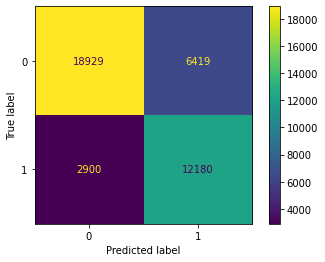

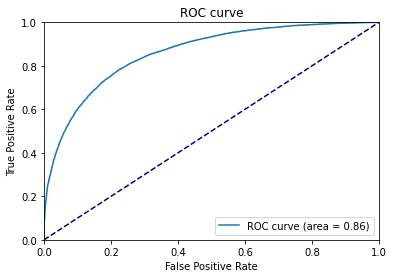

In [ ]:
evaluate_model(model, X_test, y_test)

## Experiment 4

In [ ]:
model = Sequential()
model.add(Embedding(num_distinct_words, 32))
model.add(Dropout(0.5))
model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True)))
model.add(Attention())
model.add(Dense(1, activation = 'sigmoid'))

compile_model(model)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 32)          3094048   
                                                                 
 dropout_4 (Dropout)         (None, None, 32)          0         
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 128)        49664     
 nal)                                                            
                                                                 
 attention_1 (Attention)     (None, 128)               49152     
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 3,192,993
Trainable params: 3,192,993
Non-trainable params: 0
____________________________________________

Epoch 1/10
6382/6382 [==============================] - ETA: 0s - loss: 0.5298 - accuracy: 0.7280
Epoch 1: val_loss improved from inf to 0.50832, saving model to /content/Models/BI_LSTM64_Embedding32__attention_augmented.h5
6382/6382 [==============================] - 220s 34ms/step - loss: 0.5298 - accuracy: 0.7280 - val_loss: 0.5083 - val_accuracy: 0.7443
Epoch 2/10
6381/6382 [============================>.] - ETA: 0s - loss: 0.4682 - accuracy: 0.7706
Epoch 2: val_loss improved from 0.50832 to 0.50573, saving model to /content/Models/BI_LSTM64_Embedding32__attention_augmented.h5
6382/6382 [==============================] - 210s 33ms/step - loss: 0.4682 - accuracy: 0.7706 - val_loss: 0.5057 - val_accuracy: 0.7398
Epoch 3/10
6381/6382 [============================>.] - ETA: 0s - loss: 0.4348 - accuracy: 0.7926
Epoch 3: val_loss improved from 0.50573 to 0.49754, saving model to /content/Models/BI_LSTM64_Embedding32__attention_augmented.h5
6382/6382 [==============================] - 211

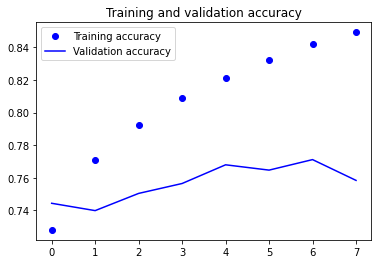

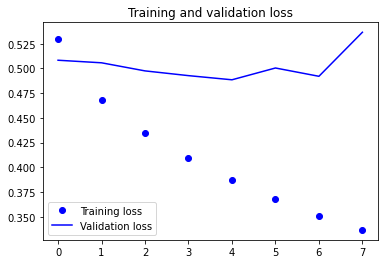

In [ ]:
run_model(model, "BI_LSTM64_Embedding32__attention_augmented", X_train_augmented, y_train_augmented, X_validation, y_validation, epochs=10, patience=3)

Classification report: 
              precision    recall  f1-score   support

           0     0.8871    0.7040    0.7850     25348
           1     0.6306    0.8495    0.7239     15080

    accuracy                         0.7583     40428
   macro avg     0.7589    0.7767    0.7545     40428
weighted avg     0.7915    0.7583    0.7622     40428



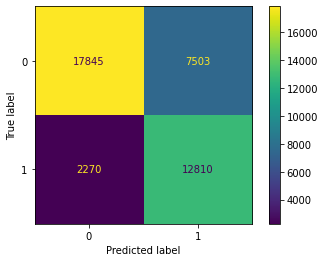

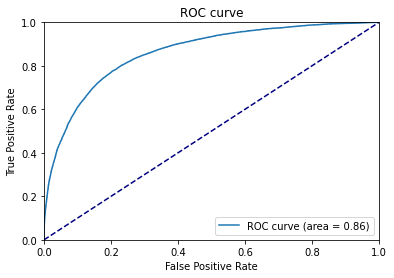

In [ ]:
evaluate_model(model, X_test, y_test)

# Total data augmentation

In [ ]:
counts = train_questions['is_duplicate'].value_counts()
counts

0    204207
1    119224
Name: is_duplicate, dtype: int64

In [ ]:
augmented_train_questions = train_questions

# We need to swap the two questions to get a new tokenizer
augmented_train_questions = augmented_train_questions.rename(columns={"qid1": "qid2", 
                        "qid2": "qid1", 
                        "question1": "question2", 
                        "question2": "question1", 
                        "question1_cleaned": "question2_cleaned", 
                        "question2_cleaned": "question1_cleaned",
                        "tokenizer_1": "tokenizer_2", 
                        "tokenizer_2": "tokenizer_1"})
augmented_train_questions['tokenizer'] = augmented_train_questions['tokenizer_1'] + augmented_train_questions['tokenizer_2']

augmented_train_questions = pd.concat([train_questions, augmented_train_questions], ignore_index=True)

In [ ]:
augmented_train_questions['is_duplicate'].value_counts()

0    408414
1    238448
Name: is_duplicate, dtype: int64

In [ ]:
y_train_augmented = augmented_train_questions[['is_duplicate']]
X_train_augmented = augmented_train_questions[['tokenizer']]
X_train_augmented = sequence.pad_sequences(X_train_augmented.tokenizer, maxlen = m_len, padding='post', truncating='post')

In [ ]:
# class weight
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(y_train),
                                                 y=y_train['is_duplicate'].tolist())

class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{0: 0.7919194738672034, 1: 1.3564005569348454}

## Experiment 1

In [ ]:
model = Sequential()
model.add(Embedding(num_distinct_words, 64))
model.add(Dropout(0.5))
model.add(layers.Bidirectional(layers.LSTM(64)))
model.add(Dense(1, activation = 'sigmoid'))

compile_model(model)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 64)          6188096   
                                                                 
 dropout_6 (Dropout)         (None, None, 64)          0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 6,254,273
Trainable params: 6,254,273
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
10107/10108 [============================>.] - ETA: 0s - loss: 0.4790 - accuracy: 0.7665
Epoch 1: val_loss improved from inf to 0.45770, saving model to /content/Models/BI_LSTM64_total_augmentation.h5
10108/10108 [==============================] - 313s 31ms/step - loss: 0.4790 - accuracy: 0.7665 - val_loss: 0.4577 - val_accuracy: 0.7828
Epoch 2/10
10107/10108 [============================>.] - ETA: 0s - loss: 0.3943 - accuracy: 0.8162
Epoch 2: val_loss improved from 0.45770 to 0.43906, saving model to /content/Models/BI_LSTM64_total_augmentation.h5
10108/10108 [==============================] - 300s 30ms/step - loss: 0.3943 - accuracy: 0.8162 - val_loss: 0.4391 - val_accuracy: 0.7961
Epoch 3/10
10108/10108 [==============================] - ETA: 0s - loss: 0.3466 - accuracy: 0.8423
Epoch 3: val_loss did not improve from 0.43906
10108/10108 [==============================] - 305s 30ms/step - loss: 0.3466 - accuracy: 0.8423 - val_loss: 0.4468 - val_accuracy: 0.8022
Epoch 4/10


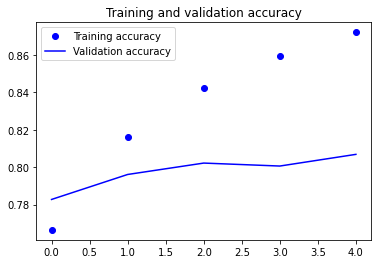

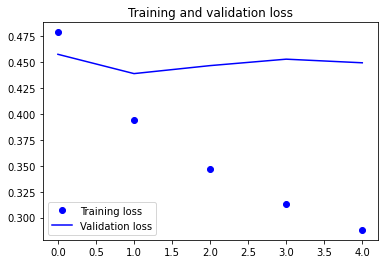

In [ ]:
run_model(model, "BI_LSTM64_total_augmentation", X_train_augmented, y_train_augmented, X_validation, y_validation, epochs=10, patience=3)

Classification report: 
              precision    recall  f1-score   support

           0     0.8508    0.8342    0.8424     25348
           1     0.7302    0.7541    0.7420     15080

    accuracy                         0.8043     40428
   macro avg     0.7905    0.7942    0.7922     40428
weighted avg     0.8058    0.8043    0.8050     40428



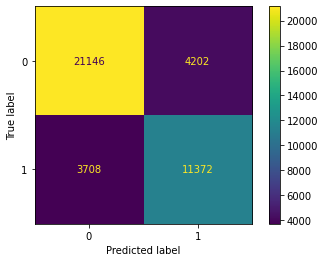

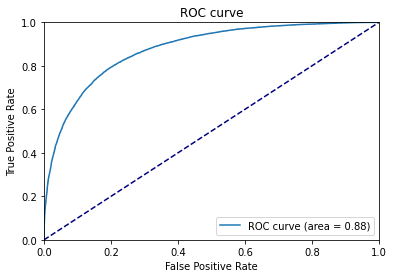

In [ ]:
evaluate_model(model, X_test, y_test)

## Experiment 2

In [ ]:
model = Sequential()
model.add(Embedding(num_distinct_words, 64))
model.add(Dropout(0.5))
model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True)))
model.add(Attention())
model.add(Dense(1, activation = 'sigmoid'))

compile_model(model)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 64)          6188096   
                                                                 
 dropout_7 (Dropout)         (None, None, 64)          0         
                                                                 
 bidirectional_7 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 attention_1 (Attention)     (None, 128)               49152     
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 6,303,425
Trainable params: 6,303,425
Non-trainable params: 0
____________________________________________

Epoch 1/10
10108/10108 [==============================] - ETA: 0s - loss: 0.4804 - accuracy: 0.7644
Epoch 1: val_loss improved from inf to 0.46775, saving model to /content/Models/BI_LSTM64_attention_total_augmentation.h5
10108/10108 [==============================] - 329s 32ms/step - loss: 0.4804 - accuracy: 0.7644 - val_loss: 0.4678 - val_accuracy: 0.7750
Epoch 2/10
10108/10108 [==============================] - ETA: 0s - loss: 0.4038 - accuracy: 0.8083
Epoch 2: val_loss improved from 0.46775 to 0.45277, saving model to /content/Models/BI_LSTM64_attention_total_augmentation.h5
10108/10108 [==============================] - 322s 32ms/step - loss: 0.4038 - accuracy: 0.8083 - val_loss: 0.4528 - val_accuracy: 0.7870
Epoch 3/10
10108/10108 [==============================] - ETA: 0s - loss: 0.3575 - accuracy: 0.8346
Epoch 3: val_loss did not improve from 0.45277
10108/10108 [==============================] - 322s 32ms/step - loss: 0.3575 - accuracy: 0.8346 - val_loss: 0.4681 - val_accuracy

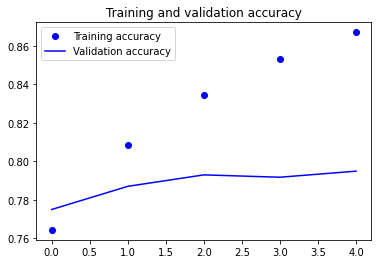

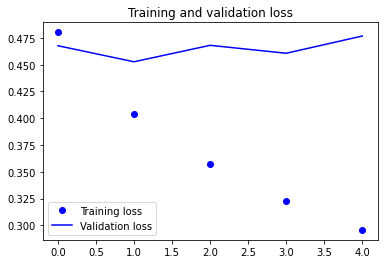

In [ ]:
run_model(model, "BI_LSTM64_attention_total_augmentation", X_train_augmented, y_train_augmented, X_validation, y_validation, epochs=10, patience=3)

Classification report: 
              precision    recall  f1-score   support

           0     0.8468    0.8201    0.8332     25348
           1     0.7128    0.7505    0.7312     15080

    accuracy                         0.7942     40428
   macro avg     0.7798    0.7853    0.7822     40428
weighted avg     0.7968    0.7942    0.7952     40428



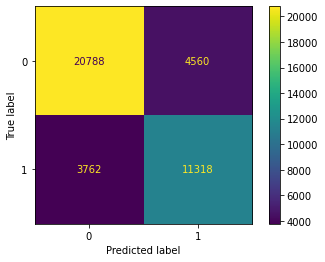

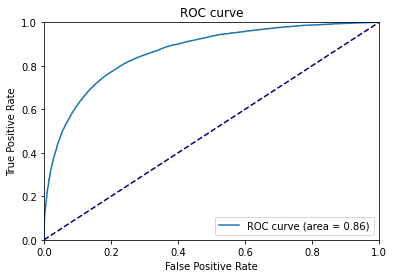

In [ ]:
evaluate_model(model, X_test, y_test)

## Experiment 3

In [ ]:
model = Sequential()
model.add(Embedding(num_distinct_words, 64))
model.add(Dropout(0.5))
model.add(layers.Bidirectional(layers.LSTM(64)))
model.add(Dense(1, activation = 'sigmoid'))

compile_model(model)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 64)          6188096   
                                                                 
 dropout_8 (Dropout)         (None, None, 64)          0         
                                                                 
 bidirectional_8 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 6,254,273
Trainable params: 6,254,273
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
10108/10108 [==============================] - ETA: 0s - loss: 0.5043 - accuracy: 0.7471
Epoch 1: val_loss improved from inf to 0.47273, saving model to /content/Models/BI_LSTM64_weights_total_augmentation.h5
10108/10108 [==============================] - 308s 30ms/step - loss: 0.5043 - accuracy: 0.7471 - val_loss: 0.4727 - val_accuracy: 0.7710
Epoch 2/10
10107/10108 [============================>.] - ETA: 0s - loss: 0.4132 - accuracy: 0.8030
Epoch 2: val_loss improved from 0.47273 to 0.46237, saving model to /content/Models/BI_LSTM64_weights_total_augmentation.h5
10108/10108 [==============================] - 302s 30ms/step - loss: 0.4132 - accuracy: 0.8031 - val_loss: 0.4624 - val_accuracy: 0.7784
Epoch 3/10
10107/10108 [============================>.] - ETA: 0s - loss: 0.3623 - accuracy: 0.8317
Epoch 3: val_loss did not improve from 0.46237
10108/10108 [==============================] - 303s 30ms/step - loss: 0.3623 - accuracy: 0.8317 - val_loss: 0.4904 - val_accuracy: 0.

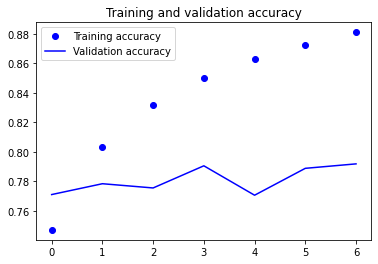

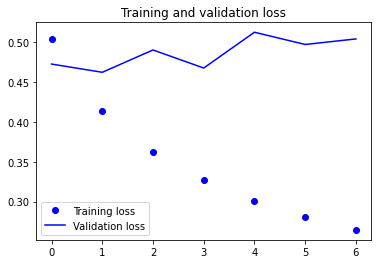

In [ ]:
run_model(model, "BI_LSTM64_weights_total_augmentation", X_train_augmented, y_train_augmented, X_validation, y_validation, epochs=10, class_weight=class_weights)

Classification report: 
              precision    recall  f1-score   support

           0     0.8780    0.7741    0.8228     25348
           1     0.6832    0.8192    0.7451     15080

    accuracy                         0.7909     40428
   macro avg     0.7806    0.7966    0.7839     40428
weighted avg     0.8053    0.7909    0.7938     40428



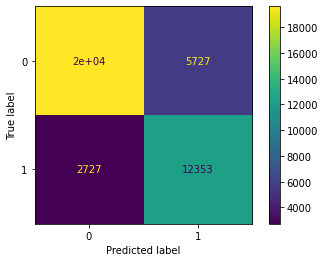

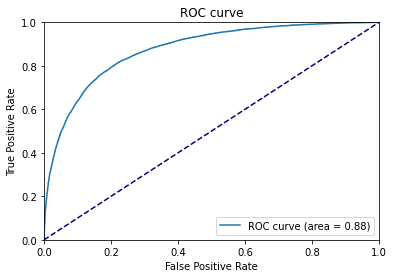

In [ ]:
evaluate_model(model, X_test, y_test)